# ★ 실무 실습) 배포 받은 "신용카드 사용자 연체 예측"를 통해 자신만의 코드를 작성 해보자

[사람의 정보를 넣어서 신용을 분류예측 하는 모델을 만들어 보자!]

1. credit: 사용자의 신용카드 대금 연체를 기준으로 한 신용도 (0,1,2)=> 낮을 수록 높은 신용의 신용카드 사용자를 의미함

2. 하나의 포트폴리오가 될 수 있도록 시각화와 통계를 자유롭게 작성해보자.
3. 이제까지 배운 분류 방법들을 통해 적용해보자.
4. 모든 기법을 다 쓰는 것보다는 필요 할 것 같다는 코드만 작성해보기

In [15]:
import numpy as np
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans

data_train = pd.read_csv('train.csv', sep=',', skiprows=[16002,23976]) # Skip the line before the error
data_train = data_train.drop_duplicates(subset=['index']).reset_index(drop=True)
data_train = data_train.fillna('no jop')
data_train.drop(columns = ['index'],inplace = True)

# 1. Label Encoding 적용 (이미 된 부분이라 가정)
label_encoder = LabelEncoder()
for column in data_train.columns:
    if data_train[column].dtype == 'object':
        data_train[column] = label_encoder.fit_transform(data_train[column].astype(str))

# 2. 범주형 열 인덱스 확인 (라벨 인코딩된 열)
categorical_features = [i for i, col in enumerate(data_train.columns) if data_train[col].dtype == 'int64']

# 3. X와 y 설정
X = data_train.iloc[:, :-1].values  # 마지막 열 제외
y = data_train.iloc[:, -1].values  # 마지막 열

# 4. 훈련 데이터와 테스트 데이터 분할 (stratify로 클래스 비율 유지)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 6. 범주형 변수를 제외한 수치형 열에 대해 스케일링 적용
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


class MultiLayerRegression(nn.Module):
    def __init__(self):
        super(MultiLayerRegression, self).__init__()
                                                # X_train이 데이터 X 피처갯수의 shape을 가지는데 거기서 인덱스 1(피처갯수)
        self.linear1 = nn.Linear(X_train.shape[1], 40)
        self.activate1 = nn.ReLU()
        self.linear2 = nn.Linear(40, 80)
        self.activate2 = nn.ReLU()
        self.linear3 = nn.Linear(80, 40)
        self.activate3 = nn.ReLU()
        self.linear4 = nn.Linear(40, 40)
        self.activate4 = nn.ReLU()




        self.linear5 = nn.Linear(40, len(set(y)))  # hidden_layer3 = 100, output_layer = len(set(y))

    def forward(self, x):
        out1 = self.linear1(x)
        out2 = self.activate1(out1)
        out3 = self.linear2(out2)
        out4 = self.activate2(out3)
        out5 = self.linear3(out4)
        out6 = self.activate3(out5)
        out7 = self.linear4(out6)
        out8 = self.activate4(out7)
        out9 = self.linear5(out8)
        return out9

model = MultiLayerRegression()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

patience = 10
best_loss = float('inf')
early_stop_counter = 0

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch)
        train_loss = criterion(y_pred, y_batch)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()

    val_loss /= len(test_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss.item():.4f}, Val Loss: {val_loss:.4f}')

    if val_loss < best_loss:
        best_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_model.pth")

    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print("Early stopping triggered")
        break


model.load_state_dict(torch.load("best_model.pth"))
model.eval()
with torch.no_grad():
    y_pred = []
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.numpy())

    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')
    report = classification_report(y_test, y_preds)
    print("Classification Report:")
    print(report)


Epoch 1/100, Loss: 1.2322, Val Loss: 0.8465
Epoch 2/100, Loss: 1.2622, Val Loss: 0.8324
Epoch 3/100, Loss: 0.8692, Val Loss: 0.8273
Epoch 4/100, Loss: 0.8800, Val Loss: 0.8244
Epoch 5/100, Loss: 0.8846, Val Loss: 0.8221
Epoch 6/100, Loss: 0.8507, Val Loss: 0.8229
Epoch 7/100, Loss: 0.7612, Val Loss: 0.8335
Epoch 8/100, Loss: 0.8845, Val Loss: 0.8221
Epoch 9/100, Loss: 0.5304, Val Loss: 0.8207
Epoch 10/100, Loss: 0.9759, Val Loss: 0.8256
Epoch 11/100, Loss: 0.7614, Val Loss: 0.8174
Epoch 12/100, Loss: 0.9878, Val Loss: 0.8262
Epoch 13/100, Loss: 1.0835, Val Loss: 0.8259
Epoch 14/100, Loss: 0.8078, Val Loss: 0.8253
Epoch 15/100, Loss: 0.9962, Val Loss: 0.8256
Epoch 16/100, Loss: 0.6346, Val Loss: 0.8263
Epoch 17/100, Loss: 0.6076, Val Loss: 0.8249
Epoch 18/100, Loss: 0.7061, Val Loss: 0.8258
Epoch 19/100, Loss: 0.7656, Val Loss: 0.8455
Epoch 20/100, Loss: 0.7584, Val Loss: 0.8452
Epoch 21/100, Loss: 0.8542, Val Loss: 0.8433
Early stopping triggered
Accuracy: 0.6864


<ipython-input-1-633654631816>:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


<ipython-input-25-1ffab8b348d0>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Accuracy: 0.6864
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.00      0.01       644
         1.0       0.64      0.25      0.36      1254
         2.0       0.69      0.98      0.81      3393

    accuracy                           0.69      5291
   macro avg       0.78      0.41      0.39      5291
weighted avg       0.72      0.69      0.61      5291



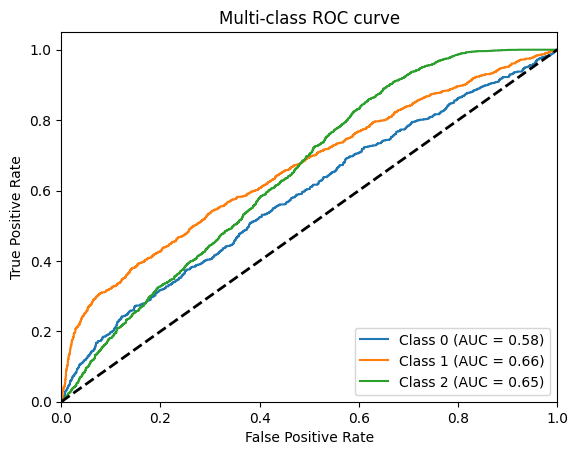

In [25]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
with torch.no_grad():
    y_pred = []
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.numpy())

    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')
    report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(report)



    # 다중 클래스 라벨을 이진화 (One-vs-Rest 방식)
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))  # 각 클래스를 이진화
    n_classes = y_test_bin.shape[1]  # 클래스 수

    # 예측 확률
    y_score = model(X_test_tensor).detach().numpy()

    # 각 클래스별 ROC 커브와 AUC 계산
    fpr = dict()  # False Positive Rate
    tpr = dict()  # True Positive Rate
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # 전체 ROC 커브 그리기
    plt.figure()

    # 클래스별 ROC 커브 그리기
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    # 대각선 선 추가 (무작위 추측 ROC 커브)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC curve')
    plt.legend(loc='lower right')
    plt.show()


AttributeError: 'MultiLayerRegression' object has no attribute 'predict_proba'

In [3]:
!pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 707.7 kB/s eta 0:00:00


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import accuracy_score



clf = TabNetClassifier()

# GPU 모드일때
#import torch
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#clf = TabNetClassifier(device_name=device.type)  # GPU 사용 설정

clf.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    max_epochs=100,
    patience=10,
    batch_size=256,
    virtual_batch_size=128
)

# 예측
preds = clf.predict(X_test)

# 성능 평가
accuracy = accuracy_score(y_test, preds)
print(f'Accuracy: {accuracy:.4f}')


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.9075  | val_0_accuracy: 0.6547  |  0:00:02s
epoch 1  | loss: 0.84406 | val_0_accuracy: 0.66263 |  0:00:05s
epoch 2  | loss: 0.83598 | val_0_accuracy: 0.6666  |  0:00:08s
epoch 3  | loss: 0.83661 | val_0_accuracy: 0.68267 |  0:00:12s
epoch 4  | loss: 0.82733 | val_0_accuracy: 0.6753  |  0:00:14s
epoch 5  | loss: 0.82474 | val_0_accuracy: 0.67284 |  0:00:16s
epoch 6  | loss: 0.82027 | val_0_accuracy: 0.68834 |  0:00:19s
epoch 7  | loss: 0.82212 | val_0_accuracy: 0.69212 |  0:00:21s
epoch 8  | loss: 0.82252 | val_0_accuracy: 0.66906 |  0:00:24s
epoch 9  | loss: 0.82541 | val_0_accuracy: 0.65489 |  0:00:27s
epoch 10 | loss: 0.82337 | val_0_accuracy: 0.68702 |  0:00:30s
epoch 11 | loss: 0.82123 | val_0_accuracy: 0.68248 |  0:00:32s
epoch 12 | loss: 0.81695 | val_0_accuracy: 0.68928 |  0:00:34s
epoch 13 | loss: 0.81686 | val_0_accuracy: 0.68702 |  0:00:37s
epoch 14 | loss: 0.81669 | val_0_accuracy: 0.67341 |  0:00:40s
epoch 15 | loss: 0.81922 | val_0_accuracy: 0.65602 |  0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Accuracy: 0.6921


In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
# 정밀도, 재현율, F1 스코어 계산
cm = confusion_matrix(y_test, preds)
print("Confusion Matrix:")
print(cm)

report = classification_report(y_test, preds)
print("Classification Report:")
print(report)

Confusion Matrix:
[[   0   80  564]
 [   0  270  984]
 [   0    1 3392]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       644
         1.0       0.77      0.22      0.34      1254
         2.0       0.69      1.00      0.81      3393

    accuracy                           0.69      5291
   macro avg       0.49      0.41      0.38      5291
weighted avg       0.62      0.69      0.60      5291



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


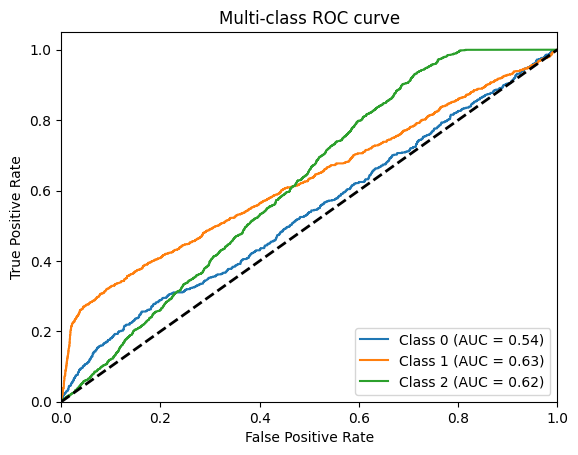

In [14]:

# 다중 클래스 라벨을 이진화 (One-vs-Rest 방식)
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))  # 각 클래스를 이진화
n_classes = y_test_bin.shape[1]  # 클래스 수

# 예측 확률
y_score = clf.predict_proba(X_test)

# 각 클래스별 ROC 커브와 AUC 계산
fpr = dict()  # False Positive Rate
tpr = dict()  # True Positive Rate
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 전체 ROC 커브 그리기
plt.figure()

# 클래스별 ROC 커브 그리기
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# 대각선 선 추가 (무작위 추측 ROC 커브)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC curve')
plt.legend(loc='lower right')
plt.show()
